<a href="https://colab.research.google.com/github/effepivi/gvxr-tutorials/blob/main/gVXR2CIL/NOTEBOOKS/GenerateIllustrationSlide.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

? 

<!-- # Session 7

## Simulating X-ray images with specific Poisson noise using ![gVXR](https://github.com/effepivi/gvxr-tutorials/blob/main/img/gvxr_logo.png?raw=1)

## Author: Franck Vidal

(version 1.0, 10 Mar 2023) -->

?

<!-- # Aims of this session

1. Add Poisson noise corresponding to a given number of photons per pixel;
2. Simulate the corresponding CT scan; and
3. Reconstruct the CT volume using the [Core Imaging Library (CIL)](https://ccpi.ac.uk/cil/). -->

?

<!-- # Main steps

1. Simulate an X-ray projection of a Welsh dragon made of quartz

![Simulation of an X-ray projection of a Welsh dragon made of quartz](https://github.com/effepivi/gvxr-tutorials/blob/main/PoissonNoise/visualisation.png?raw=1)

2. Select the number of incident photons per pixel
3. Add the corresponding amount of Photonic noise 

![X-ray projection with Poisson noise](https://github.com/effepivi/gvxr-tutorials/blob/main/PoissonNoise/noisy-projection.png?raw=1)

4. Simulate a CT scan

![Scanning eometry](https://github.com/effepivi/gvxr-tutorials/blob/main/PoissonNoise/CT-geometry.png?raw=1)

5. Create the flat-field images with the corresponding amount of Photonic noise

![Average flat-field image with Poisson noise](https://github.com/effepivi/gvxr-tutorials/blob/main/PoissonNoise/average-flat-field.png?raw=1)

6. Reconstruct the CT volume using the [Core Imaging Library (CIL)](https://ccpi.ac.uk/cil/)

![Visualisation of the reconstructed 3D volume](https://github.com/effepivi/gvxr-tutorials/blob/main/PoissonNoise/plotCT.png?raw=1) -->

In [1]:
# !pip install -q condacolab
# import condacolab
# condacolab.install()

?

<!-- # Install gVXR, k3D, imagecodecs xpecgen, spekpy and SimpleITK

Run the cell below

```python
!pip3 install gvxr k3d imagecodecs xpecgen git+https://bitbucket.org/spekpy/spekpy_release.git SimpleITK #itk-rtk
``` -->

In [2]:
# !pip3 install gvxr k3d imagecodecs xpecgen git+https://bitbucket.org/spekpy/spekpy_release.git SimpleITK #itk-rtk

In [3]:
# !mamba install -c conda-forge -c intel -c astra-toolbox -c ccpi cil numpy astra-toolbox --quiet

In [4]:
%matplotlib inline

# Copy files

This step is needed when the notebook is executed using Goggle Collaborative

Download the Sample if needed

In [5]:
import os
import urllib.request
import matplotlib.pyplot as plt # Plotting

output_path = "../output_data/Illustrations"

def createDirectory(directory):
    # The directory does not exist
    if not os.path.exists(os.path.abspath(directory)):
    
        # Create the directory
        os.mkdir(os.path.abspath(directory))

def downloadFile(fname):
    if not os.path.exists(fname):
        base_url = "https://github.com/effepivi/gvxr-tutorials/raw/main"
        url = base_url + "/" + fname
        print("Download the polygon mesh (%s)" % fname)
        urllib.request.urlretrieve(url, fname)

createDirectory("../JSON")
createDirectory("../input_data")
createDirectory("../output_data")
createDirectory(output_path)

# downloadFile("input_data/welsh-dragon-small.stl")
# downloadFile("energyResponseDetector.txt")
# downloadFile("JSON/PoissonNoise.json")
# downloadFile("output_data/visualisation.png")

In [6]:
# import glob

import json

# from IPython.display import display
# from IPython.display import Image

# import matplotlib.pyplot as plt # Plotting
import numpy as np

# from tifffile import imread, imwrite

# from IPython.display import display
# from IPython.display import Image

# import SimpleITK as sitk

import matplotlib
import matplotlib.pyplot as plt # Plotting

font = {'family' : 'serif',
        #'weight' : 'bold',
         'size'   : 25.5
       }
matplotlib.rc('font', **font)
matplotlib.rc('text', usetex=True)


# # import itk
# # from itk import RTK as rtk

# has_cil = True
# try:
#     # from cil.utilities.jupyter import islicer
#     from cil.processors import TransmissionAbsorptionConverter
#     from cil.utilities.display import show_geometry, show2D
#     from cil.recon import FBP, FDK
#     from cil.plugins.astra.processors.FDK_Flexible import FDK_Flexible
#     print("CIL detected")
# except:
#     has_cil = False
#     print("CIL not detected")
    
# has_tigre = True
# try:
#     import tigre
#     print("Tigre detected")
# except:
#     has_tigre = False
#     print("Tigre not detected")

# from ipywidgets import interact
# import ipywidgets as widgets

# import base64

import random

from gvxrPython3 import gvxr
from gvxrPython3 import json2gvxr
# from gvxrPython3.utils import visualise
from gvxrPython3.utils import plotScreenshot
# from gvxrPython3.utils import interactPlotPowerLaw # Plot the X-ray image using a Power law look-up table
# from gvxrPython3.utils import saveProjections # Plot the X-ray image in linear, log and power law scales

# if has_cil:
#     from gvxrPython3.JSON2gVXRDataReader import *

from gvxrPython3.JSON2gVXRDataReader import *
from cil.recon import FDK

K3D is not install, you won't be able to visualise the 3D scene using k3D
spekpy is not install, you won't be able to load a beam spectrum using spekpy
SimpleGVXR 2.0.5 (2023-03-09T10:57:28) [Compiler: GNU g++] on Linux
gVirtualXRay core library (gvxr) 2.0.5 (2023-03-09T10:57:28) [Compiler: GNU g++] on Linux


## Initialise GVXR using our JSON file

In [7]:
json_fname = "../JSON/Slide.json"
json2gvxr.initGVXR(json_fname, renderer="OPENGL")

Create an OpenGL context: 900x350


Fri Mar 17 16:54:28 2023 ---- Create window (ID: -1)
Fri Mar 17 16:54:28 2023 ---- Initialise GLFW
Fri Mar 17 16:54:28 2023 ---- Create an OpenGL window with a 3.2 context.
Fri Mar 17 16:54:29 2023 ---- Make the window's context current
Fri Mar 17 16:54:29 2023 ---- Initialise GLEW
Fri Mar 17 16:54:29 2023 ---- OpenGL vendor: NVIDIA Corporation
Fri Mar 17 16:54:29 2023 ---- OpenGL renderer: NVIDIA GeForce RTX 2080 Ti/PCIe/SSE2
Fri Mar 17 16:54:29 2023 ---- OpenGL version: 3.2.0 NVIDIA 515.76
Fri Mar 17 16:54:29 2023 ---- Use OpenGL 4.5.
Fri Mar 17 16:54:29 2023 ---- Initialise the X-ray renderer if needed and if possible


In [8]:
json2gvxr.initSamples(verbose=1)
gvxr.moveToCentre()

ID = "root"
min_x, min_y, min_z, max_x, max_y, max_z = gvxr.getNodeAndChildrenBoundingBox(ID, "mm")

centre_x = (min_x + max_x) / 2.0
centre_y = (min_y + max_y) / 2.0
centre_z = (min_z + max_z) / 2.0

print("Bounding box:", [min_x, min_y, min_z], [max_x, max_y, max_z])
print("Bounding box centre:", [centre_x, centre_y, centre_z])

Load the 3D data

	Load internals in /home/fpvidal/PROGRAMMING/GitHub/gVXR2CIL/JSON/../input_data/TurboPump/internals.stl using mm


Fri Mar 17 16:54:29 2023 ---- file_name:	/home/fpvidal/PROGRAMMING/GitHub/gVXR2CIL/JSON/../input_data/TurboPump/internals.stl	nb_faces:	86276	nb_vertices:	258828	bounding_box (in cm):	(-3.48613, -5.55, -3.48613)	(3.48613, -0.735, 3.48613)


	Load front_flange in /home/fpvidal/PROGRAMMING/GitHub/gVXR2CIL/JSON/../input_data/TurboPump/front_flange.stl using mm
	Load rear_flage in /home/fpvidal/PROGRAMMING/GitHub/gVXR2CIL/JSON/../input_data/TurboPump/rear_flange.stl using mm
	Load housing in /home/fpvidal/PROGRAMMING/GitHub/gVXR2CIL/JSON/../input_data/TurboPump/housing.stl using mm
	Load roller_bearing in /home/fpvidal/PROGRAMMING/GitHub/gVXR2CIL/JSON/../input_data/TurboPump/ThrustRollerBearing.stl using mm
Bounding box: [-28.82575225830078, -29.8372802734375, -19.06999969482422] [28.825754165649414, 29.8372802734375, 19.07000160217285]
Bounding box centre: [9.5367431640625e-07, 0.0, 9.5367431640625e-07]


Fri Mar 17 16:54:29 2023 ---- file_name:	/home/fpvidal/PROGRAMMING/GitHub/gVXR2CIL/JSON/../input_data/TurboPump/front_flange.stl	nb_faces:	6120	nb_vertices:	18360	bounding_box (in cm):	(-11.425, 0, -11.425)	(11.425, 3.535, 11.425)
Fri Mar 17 16:54:29 2023 ---- file_name:	/home/fpvidal/PROGRAMMING/GitHub/gVXR2CIL/JSON/../input_data/TurboPump/rear_flange.stl	nb_faces:	10516	nb_vertices:	31548	bounding_box (in cm):	(-11.425, -15.535, -11.425)	(11.425, -6.73, 11.425)
Fri Mar 17 16:54:29 2023 ---- file_name:	/home/fpvidal/PROGRAMMING/GitHub/gVXR2CIL/JSON/../input_data/TurboPump/housing.stl	nb_faces:	35076	nb_vertices:	105228	bounding_box (in cm):	(-12.3086, -8.5025, -14.9408)	(16.5171, 1.8975, 14.8965)
Fri Mar 17 16:54:29 2023 ---- file_name:	/home/fpvidal/PROGRAMMING/GitHub/gVXR2CIL/JSON/../input_data/TurboPump/ThrustRollerBearing.stl	nb_faces:	26384	nb_vertices:	79152	bounding_box (in cm):	(-6.25, -9.27, -6.25)	(6.25, -6.77, 6.25)


In [9]:
spectrum, unit_of_energy, energy_set, bin_sets = json2gvxr.initSpectrum(verbose=0)

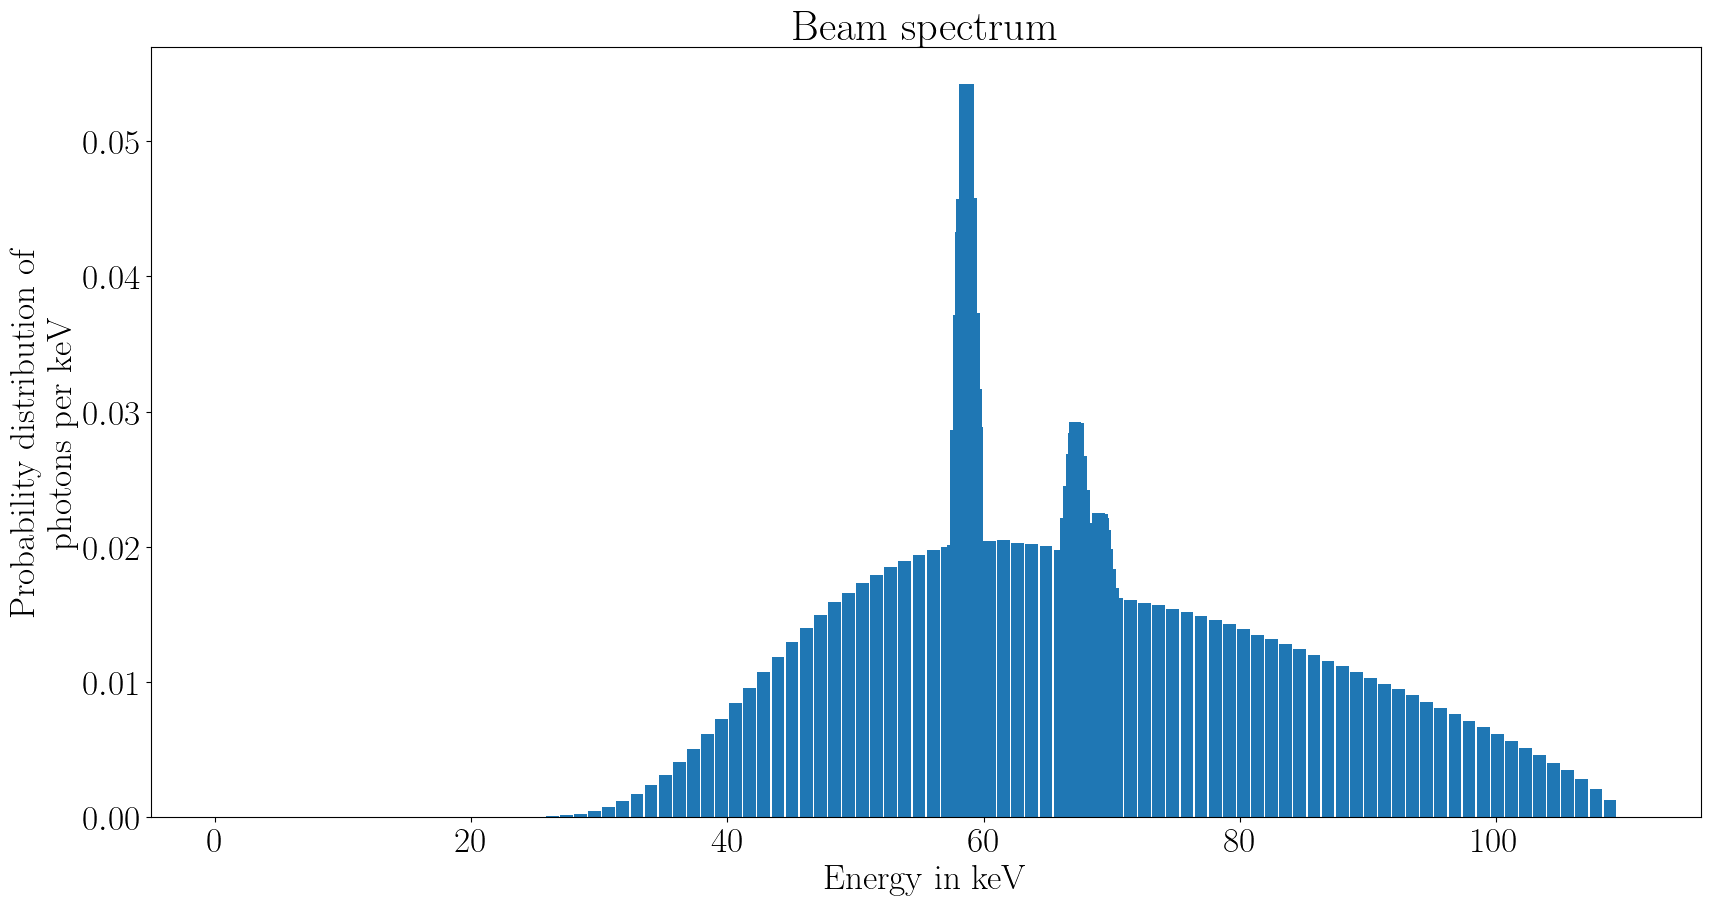

In [10]:
plt.figure(figsize= (20,10))
plt.title("Beam spectrum")
plt.bar(energy_set, bin_sets, width=1)
plt.xlabel('Energy in ' + unit_of_energy)
plt.ylabel('Probability distribution of\n photons per keV')
plt.savefig(output_path + "/spectrum.png")

In [11]:
json2gvxr.initDetector(json_fname)
json2gvxr.initSourceGeometry()

Set up the detector
	Detector position: [-150, 0, 0, 'mm']
	Detector up vector: [0, 0, 1]
	Number of pixels: [900, 900]
	Detector number of pixels: [900, 900]
	Pixel spacing: [0.2, 0.2, 'mm']
Set up the beam
	Source position: [200, 0, 0, 'mm']
	Source shape: Point


Fri Mar 17 16:54:33 2023 ---- Initialise the renderer


In [12]:
zoom = 350

gvxr.displayScene()
gvxr.setZoom(zoom)
gvxr.displayScene()

matrix = gvxr.getSceneRotationMatrix()

In [13]:
gvxr.setWindowBackGroundColour(1,1,1)
gvxr.displayBeam(False)
gvxr.displayScene()

In [14]:
fname = output_path + '/s0.png'

if not os.path.exists(fname):
    screenshot = np.array(gvxr.takeScreenshot(), dtype=np.single)
    matplotlib.image.imsave(fname, screenshot)

In [15]:
fname = output_path + '/s2.png'

if not os.path.exists(fname):
    screenshot = np.array(gvxr.takeScreenshot(), dtype=np.single)
    matplotlib.image.imsave(fname, screenshot)

In [16]:
gvxr.displayBeam(True)
gvxr.displayScene()

In [17]:
fname = output_path + '/s3.png'

if not os.path.exists(fname):
    screenshot = np.array(gvxr.takeScreenshot(), dtype=np.single)
    matplotlib.image.imsave(fname, screenshot)

In [18]:
projection_in_MeV = np.array(gvxr.computeXRayImage(), dtype=np.single)
projection_in_keV = projection_in_MeV / gvxr.getUnitOfEnergy("keV")
gvxr.displayScene()

In [19]:
fname = output_path + '/s4.png'

if not os.path.exists(fname):
    screenshot = np.array(gvxr.takeScreenshot(), dtype=np.single)
    matplotlib.image.imsave(fname, screenshot)

In [20]:
json2gvxr.initScan(json_fname)
gvxr.setSceneRotationMatrix(matrix)
gvxr.setZoom(zoom)

Set up the CT Scan


In [21]:
angles = json2gvxr.doCTScan(verbose=False)

In [ ]:
gvxr.terminate()

ModuleNotFoundError: No module named 'cil'

In [ ]:
reader = JSON2gVXRDataReader(file_name=json_fname)
data = reader.read()

In [ ]:
show_geometry(data.geometry)

In [ ]:
data.reorder(order='tigre')
data_corr = TransmissionAbsorptionConverter(white_level=data.max())(data)

In [ ]:
ig = data.geometry.get_ImageGeometry()

# ig.voxel_num_x = 600
# ig.voxel_num_y = 600
# ig.voxel_num_z = 700

recons = FDK(data_corr, ig).run()

In [ ]:
islicer(recons, direction='vertical')

In [ ]:
islicer(recons, direction='horizontal_x')